<a href="https://colab.research.google.com/github/amazzoli/Quantitative_immunology/blob/main/notebooks/ALICE_enrichment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [4]:
%%bash
git clone https://github.com/amazzoli/Quantitative_immunology.git

Cloning into 'Quantitative_immunology'...


# Finding the clusters of clonotypes significantly expanded

Given a sample of clonotype sequences we want to find which clonotypes (and their neighbours) are potentially interacting with a pathogen or a vaccine.
To this end, here we implement the ideas at the base of the bioinformatic tool ALICE, https://github.com/pogorely/ALICE.

This algorithm computes a null model for the nummber of nearest neighbours that each amino-acid sequence of a receptor is expected to have, according to a random process that generates sequences with a probability $P_{gen}$, obtained through the modelling of the VDJ recombination.

One can compute (see lecture notes) that the probability of having $d$ neighbours of a sequence $x$ is:
\begin{equation}
P(d|x) = \frac{e^{-\lambda} λ^d}{d!} \hspace{0.5cm} \text{ where } λ = N Q \sum_{x'\in \mathcal{N}(x)} P_{gen}(x)
\end{equation}
where $N$ is the number of sequences in the dataset and $Q$ is a factor correcting for the thymic selection of the receptor.

### Computing λ
Let us first compute the value of lambda for each sequence, given the table in which we previously computed $\sum_{x'\in \mathcal{N}(x)} P_{gen}(x)$

In [24]:
data_folder = 'Quantitative_immunology/data/'
frame = pd.read_csv(data_folder+'sequences_pgen_neigh.tsv', sep='\t', index_col=0)

In [25]:
# Total number of sequences
N = len(frame)

# Estimated value of Q
Q = 9.41

# Keeping only sequences with more than 2 neighbours, for which the neighbour pgen 
# have been computed
frame = frame[frame['n_neigh'] > 2]
# Collapsing together sequences with the same amino-acid sequence
frame = frame.groupby('CDR3_aa').agg('first')
# Keeping only the fields relevant for the analysis
frame = frame[['Pgen_neigh', 'n_neigh']]

In [26]:
frame['N_neigh_expected'] = frame['Pgen_neigh'] * N * Q
frame

,Pgen_neigh,n_neigh,N_neigh_expected
CDR3_aa,,,
CAAGGSSYNEQFF,1.718038e-06,3,2.880540
CAAGSQETQYF,1.179575e-06,4,1.977729
CAAGTDTQYF,5.353817e-06,3,8.976454
CAARGSGANVLTF,1.601421e-06,3,2.685016
CAARRDSNYGYTF,1.345133e-07,3,0.225531
...,...,...,...
CSVVTSGYNEQFF,2.867936e-07,3,0.480851
CSVVVGGTEAFF,1.536127e-07,4,0.257554
CSVVYNEQFF,1.242920e-06,3,2.083937


### Computing the p-value for having more neighbours than expected by chance

The p value is the probability that a sequence of our null model has the same or a larger number of nearest neighbours.
If a sequence $x$ has $d(x)$ neighbours, its p-value is
\begin{equation}
p_v (x) = \sum_{d' \ge d(x)} P(d'|x) = 1 - \text{cdf}(d(x)|x),
\end{equation}
where in the second expression we have $\text{cdf}(d|x)$ as the cumulative distribution of $P(d|x)$.
This allows us to cumpute fastly the summation over d, since the cumulative of the Poissonian is contained in a python function.

In [27]:
def compute_p_val(row):
    lambd = row['N_neigh_expected']
    # The p-value can be obtained with the poisson cdf
    row['p_val'] = 1 - poisson.cdf(row['n_neigh'], lambd)
    return row

# This operation will take a few minutes
frame = frame.apply(compute_p_val, axis=1)

In [28]:
frame

,Pgen_neigh,n_neigh,N_neigh_expected,p_val
CDR3_aa,,,,
CAAGGSSYNEQFF,1.718038e-06,3.0,2.880540,0.326026
CAAGSQETQYF,1.179575e-06,4.0,1.977729,0.050666
CAAGTDTQYF,5.353817e-06,3.0,8.976454,0.978418
CAARGSGANVLTF,1.601421e-06,3.0,2.685016,0.282607
CAARRDSNYGYTF,1.345133e-07,3.0,0.225531,0.000090
...,...,...,...,...
CSVVTSGYNEQFF,2.867936e-07,3.0,0.480851,0.001521
CSVVVGGTEAFF,1.536127e-07,4.0,0.257554,0.000008
CSVVYNEQFF,1.242920e-06,3.0,2.083937,0.158332


### Correcting for multiple testing

The procedure above gives us almost $m ≈ 50000$ p-values and we would like to select the significant ones with a confidence of $α = 0.001$.
Of course, it is possible that even if they are all non-significant, just by chance and becaouse we are repeating the measure som many times, some of them are significant.
To correct for this effect, i.e. multiple testing, we employ the **Bonferroni correction**, one of the simplest and more popular corrections.
It states that we have to consider an effective threshold of confidence that is $α' = α / m$.
Equivalently, we can multiply each p-value by $m$ and keep the ones at significance $α$.

In [29]:
frame['p_val_bonf'] = frame['p_val'] * len(frame)

In [30]:
alpha = 0.001
candidates = frame[frame['p_val_bonf'] < alpha]
candidates

,Pgen_neigh,n_neigh,N_neigh_expected,p_val,p_val_bonf
CDR3_aa,,,,,
CASGPGTGVIEQYF,1.819936e-08,4.0,0.030514,2.149149e-10,1.015623e-05
CASGPGTGVLEQYF,2.288825e-08,4.0,0.038375,6.717467e-10,3.174473e-05
CASGPGTGVVEQYF,2.181708e-08,4.0,0.036580,5.293896e-10,2.501737e-05
CASGSPSSYEQYV,1.480141e-08,3.0,0.024817,1.549345e-08,7.321738e-04
CASIPGTGPYEQYV,1.333069e-08,3.0,0.022351,1.021415e-08,4.826900e-04
...,...,...,...,...,...
CSVGAGWGMNTEAFF,5.692369e-09,4.0,0.009544,6.546985e-13,3.093909e-08
CSVGPGWGMNTEAFF,9.973583e-09,5.0,0.016722,2.997602e-14,1.416577e-09
CSVGRMNTEAFF,1.091496e-06,13.0,1.830051,9.892278e-09,4.674794e-04


As a result, we have around 400 receptors with a number of similar other receptors much larger than expected by a random model.
Those are good candidates for interacting with the vaccine and can be a precious information for biologist and biotechnologist to develop new strategies in diagnostics and treatements.

### Inspecting the structure of some clusters

The properties of a group of similar sequences can be highlighted using the sequence logo, which shows the frequency of each aminoacid at each position.

In [32]:
!pip install atriegc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for atriegc: filename=atriegc-0.0.3-cp310-cp310-linux_x86_64.whl size=1368256 sha256=7ec06414468e279110e8b74b2535a2e19fdfca7e14e5b657d58890912018ef9e
  Stored in directory: /root/.cache/pip/wheels/7d/09/7e/5d3f2397e7b4c53204a14241e0b78b806e0d96e7fe5774cae5
Successfully built atriegc


In [38]:
!pip install logomaker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 77.7 MB/s eta 0:00:00


Building the clusters of similar sequences among the good candidates

In [34]:
import atriegc

trie = atriegc.TrieAA()
trie.insert_list(candidates.index.values)
clusters_dict = trie.clusters(1)

In [59]:
# List of siquences for each cluster
clusters = [[] for _ in range(max(clusters_dict.values()))]
# Length of each cluster
cluster_len = np.zeros(max(clusters_dict.values()))

for k, v in clusters_dict.items():
    clusters[v-1].append(k)
    cluster_len[v-1] += 1

Selecting the cluster to analyse

In [63]:
largest_cluster_i = np.argsort(cluster_len)[-2]
cl = clusters[largest_cluster_i]
print(cl)

['CASSQETAPNTDTQYF', 'CASSQETYPNTDTQYF', 'CASSQENKPSTDTQYF', 'CASSQETNPSTDTQYF', 'CASSQETFPSTDTQYF', 'CASSQEYYPSTDTQYF', 'CASSQENYPSTDTQYF', 'CASSQEGLPNTDTQYF', 'CASSQEHIPSTDTQYF', 'CASSQETVPSTDTQYF', 'CASSQEGQPNTDTQYF', 'CASSQEGSPNTDTQYF', 'CASSQETSPSTDTQYF', 'CASSQETHPSTDTQYF', 'CASSQETMPSTDTQYF', 'CASSQEMAPSTDTQYF', 'CASSQEAGPNTDTQYF', 'CASSQEQRPSTDTQYF', 'CASSQESYPSTDTQYF', 'CASSQESFPSTDTQYF', 'CASSQESLPSTDTQYF', 'CASSQESVPSTDTQYF', 'CASSQESAPSTDTQYF', 'CASSQESSPSTDTQYF', 'CASSQEAFPSTDTQYF', 'CASSQEAQPSTDTQYF', 'CASSQEASPSTDTQYF', 'CASSQEARPSTDTQYF', 'CASSQEGIPSTDTQYF', 'CASSQEGAPSTDTQYF', 'CASSQEGPPSTDTQYF', 'CASSQEGQPSTDTQYF', 'CASSQEGSPSTDTQYF', 'CASSQEGHPSTDTQYF', 'CASSQEMGPSTDTQYF', 'CASSQESGPSTDTQYF', 'CASSQEWTPSTDTQYF', 'CASSQEATPSTDTQYF', 'CASSQEGTPSTDTQYF', 'CASSQEGPPNTDTQYF', 'CASSQEGVPNTDTQYF', 'CASSQEAAPSTDTQYF', 'CASSQEGYPSTDTQYF', 'CASSQEQGPSTDTQYF', 'CASSQEGGPSTDTQYF', 'CASSQEAAPNTDTQYF', 'CASSQEHAPSTDTQYF', 'CASSQEQAPSTDTQYF', 'CASSQETYPSTDTQYF', 'CASSQESIPSTDTQYF',

Building the frequencies of amino-acids at each position

In [64]:
aa_alphabet = 'RHKDESTNQCGPAVILMFYW'

logo_matrix = np.zeros((len(cl[0]), 20))
logo_df = pd.DataFrame(logo_matrix, columns=[l for l in aa_alphabet])
N_seq = len(cl)

for s in cl:
  for i in range(len(s)):
    logo_df.loc[i, s[i]] += 1/N_seq

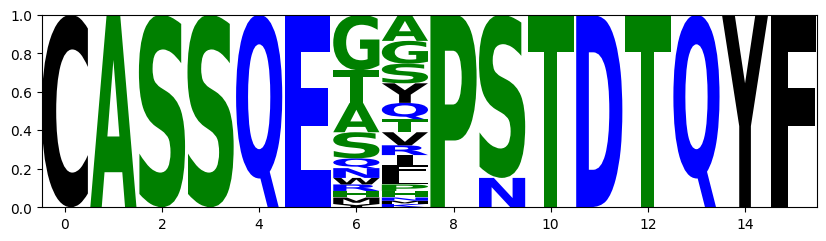

In [67]:
import logomaker
logomaker.Logo(logo_df, color_scheme='hydrophobicity')